# Clustering Noisy Rings

This assignment is inspired by a real subproblem from LHCb experiment conducted at CERN, although we will work on a much simpler version. RICH (Ring Imaging CHerenkov) detectors try to detect round/elliptic patterns which are caused by the impact of Cherenkov radiation: cones of photons emitted by particles resulting from hadrons collisions when such particles travel through a special gas at a speed higher than the speed of light in that gas medium.

Nevertheless, we will skip all physical details in this assignment, reformulating the problem as follows: Given a cloud of points within a given range (for example, a 100x100 square area), the goal is to find the set of “rings” in such a way that all points from the cloud fit into those rings. Of course, we assume that there will be some noise, so we do not expect a perfect fit, we just try to minimize the error.

The main goals of this assignment are:

    1. You are expected to design and implement an adapted clustering algorithm that searches for circumferences, and takes uncertainty explicitly into account. That is, each cluster will be represented by a circumference (e.g. providing its center and radius), while each point can be associated with several (all) clusters, but featuring different “membership degree”.

    2. You are expected to run a battery of experiments, understand the behaviour of the algorithm, analyze the results, and be able to present them in written and oral form.

To be submitted:

    1. Source code.
    2. pdf report including: introduction, explanation of the implemented algorithm, overview of the experimental results, conclusions and bibliography.



In [1]:
# These are the libraries that I have used to implement the code.

from matplotlib import pyplot as plt
import random
import math

In [2]:
def generatePoints():
    
    # This is the number of points reserved for all the circles.
    
    numberPointsCircles = (1-noise)*numberPoints
    
    # This list of lists will contain the coordinates of all the points that form a circle for each circle.
    
    circlesPoints = []
    
    # This list will contain the coordinates of all the points that were randomly generated and do not belong 
    # to a circle. The number of randomPoints depends on the noise given earlier.
    
    randomPoints = []
    
    # This list contains the coordinates and radius of all circles.
    
    circles = []
    
    while len(circles) != numberCircles:
        
        centerCoordinate = (random.uniform(0,maximumLengthInX),random.uniform(0,maximumLengthInY))
        
        # Random radius between the given range
        
        radius = random.uniform(minRadius, maxRadius)
        
        circle = (centerCoordinate, radius)
        if circle not in circles:
            circles.append(circle)
    
    # sumRadius informaton will later be used to distribute the number of points each circle has.
    
    sumRadius = sum([circle[1] for circle in circles])
    
    # Inside this loop, every calculation necessary to obtain the points of each circle are made.
    
    for circle in circles:
        
        # Depending on the radius of the circle, the circle will be formed with less or more points. Circles with a 
        # bigger value of radius will be formed with more points.
        
        numberPointsCircle = round(numberPointsCircles * (circle[1]/sumRadius))
        
        # This list will contain random angles which will later be used to calculate the position of a point in a
        # circle.
        
        angles = []
        while len(angles) != numberPointsCircle:
            angle=random.uniform(0, 2*math.pi)
            if angle not in angles:
                angles.append(angle)
        
        # With the list of angles calculated before, we generate the points that correspond to a circle. The list
        # of points that form this circle are added to the list circlesPoints.
        
        circlesPoints.append([(circle[0][0]+circle[1]*math.cos(angle),circle[0][1]+circle[1]*math.sin(angle)) 
                              for angle in angles])
    
    # All the coordinates of all the points calculated are put into a single list. This is the data
    # regarding the points that the Fuzzy C-Means algorithm algorithm will receive and use.
    
    points=[]
    for circlePoints in circlesPoints:
        points.extend(circlePoints)
    
    # All calculations regarding the circles are done. The only thing left is calculate the points that does not
    # belong to a circle. 
    
    while len(randomPoints) != (numberPoints - len(points)):
        randomPoint= (random.uniform(0,maximumLengthInX),random.uniform(0,maximumLengthInY))
        if randomPoint not in circlesPoints:
            randomPoints.append(randomPoint)

    points.extend(randomPoints)

    return circles, circlesPoints, randomPoints, points 

In [3]:
def plotPoints(circles, circlesPoints, randomPoints):
    
    # First the points of each circle are plotted.
    
    for i in range(len(circles)):
        pointsX = [point[0] for point in circlesPoints[i]]
        pointsY = [point[1] for point in circlesPoints[i]]
        plt.scatter(pointsX,pointsY)
    
    # Then the random points are plotted.
    
    randomPointsX = [point[0] for point in randomPoints]
    randomPointsY = [point[1] for point in randomPoints]
    
    plt.scatter(randomPointsX, randomPointsY)

In [4]:
#   Using Pythagorean theorem, this function returns the Euclidean distance between two points.

def distanceBetweenTwoPoints(p1, p2):
    x = pow(p1[0]-p2[0], 2)
    y = pow(p1[1]-p2[1], 2)
    return pow((x+y),0.5)

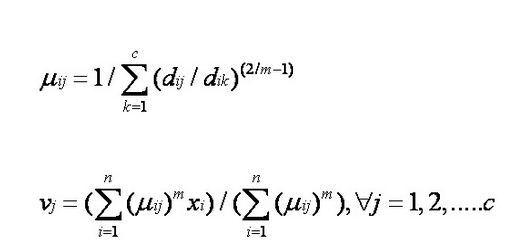

In [5]:
# Detailed information about the following steps are shown in the attached document under the section about 
# Fuzzy c-Means algorithm.

def fuzzyCMeans(maximumLengthInX, maximumLengthInY, numberCircles, fuzziness, points, iterations):
    
    # Step 1: Create as many centroids as clusters you desire (In this case, as many clusters as the number of circles).
    
    circlesFCM = []
    while len(circlesFCM) != numberCircles:
        center = (random.uniform(0,maximumLengthInX),random.uniform(0,maximumLengthInY))
        if center not in circlesFCM:
            circlesFCM.append(center)
    
    for k in range(iterations):
        
        # Step 2: For each data point, calculate the membership 
        # degree of the data point to each centroid.

        membership = []
        for point in points:
            membership.append([])
            for center in circlesFCM:
                membership[-1].append(1/sum([pow(distanceBetweenTwoPoints(point, center)/
                                                 distanceBetweenTwoPoints(point, center2), 2/(fuzziness-1)) 
                                                 for center2 in circlesFCM]))
        
        # Step 3: Recalculate the position of the centroid of each cluster based on the 
        # previous data.

        for j in range(len(circlesFCM)):
                numeratorX = 0
                numeratorY = 0
                denominator = 0
                for i in range(len(points)):
                    numeratorX += pow(membership[i][j], fuzziness)*points[i][0]
                    numeratorY += pow(membership[i][j], fuzziness)*points[i][1]
                    denominator += pow(membership[i][j], fuzziness)
                circlesFCM[j]=(numeratorX/denominator, numeratorY/denominator)
    
    
    radius = []
    for j in range(len(circlesFCM)):
        radius.append(0)
        for i in range(len(points)):
            radius[-1] += pow(membership[i][j], fuzziness)*distanceBetweenTwoPoints(points[i], circlesFCM[j])
        radius[-1] /= sum([pow(membership[i][j], fuzziness) for i in range(len(points))])

    for j in range(len(circlesFCM)):
        circlesFCM[j] = (circlesFCM[j], radius[j])
    
    return circlesFCM;

In [6]:
def plotCenters(circlesFCM):
    for i in range(len(circlesFCM)):
        ax.add_patch(plt.Circle(circlesFCM[i][0],circlesFCM[i][1], color='black', fill=False))
        plt.scatter(circlesFCM[i][0][0],circlesFCM[i][0][1],c="#000000")

In [7]:
 # This function its explained in detail in the attached document

def calculatePairOfCircles(circles, circlesFCM):
    
    pairOfCircles = []
    
    distanceBetweenCircles = []
    
    for circle in circles:
        
        circleList=[]
        for circleFCM in circlesFCM:
            circleList.append(distanceBetweenTwoPoints(circle[0], circleFCM[0]))
        distanceBetweenCircles.append(circleList)
    
    while( len(circles) != 0):
           
        distances = []
        for row in distanceBetweenCircles:
            distances.extend(row)

        minDistance = min(distances)
        
        i=0
        j=0
        
        for k in range(len(distanceBetweenCircles)):
            if minDistance in distanceBetweenCircles[k]:
                i = k
                j = distanceBetweenCircles[k].index(minDistance)
                pairOfCircles.append([circles[k], circlesFCM[j]]) 
                circles.remove(circles[k])
                circlesFCM.remove(circlesFCM[j])
        
        distanceBetweenCircles.remove(distanceBetweenCircles[i])
            
        for k in range(len(distanceBetweenCircles)):
            distanceBetweenCircles[k].remove(distanceBetweenCircles[k][j])
        
    return pairOfCircles

In [8]:
def calculateError(pairsOfCircles):
    
    # This list contains the errors of all pairs of circles
    
    errors = []
    
    for pairOfCircle in pairsOfCircles:
        
        distance = distanceBetweenTwoPoints(pairOfCircle[0][0], pairOfCircle[1][0])
        
        distanceError = 0
        
        #  If the pair of circles are not overlapping the error is 100%
        if distance >= pairOfCircle[0][1] + pairOfCircle[1][1]:
            distanceError = 100
        else:
            distanceError = distance / (pairOfCircle[0][1] + pairOfCircle[1][1]) * 100
        
        radiusError = 100 - min([pairOfCircle[0][1], pairOfCircle[1][1]])/max([pairOfCircle[0][1], pairOfCircle[1][1]])*100
        
        error=[]
        error.append(distanceError)
        error.append(radiusError)
        error.append((distanceError+radiusError)/2)
        errors.append(error)
    
    average = sum([error[2] for error in errors])/len(errors)
    
    return errors, average 

In [9]:
def plotError(pairOfCircles, errors, average, iteration):
    
    iterationText = '### ITERATION '+str(iteration+1)+' ###'
    plt.text(0, -0.2, iterationText, ha='left', wrap=True, transform=plt.gca().transAxes)
    
    for i in range(len(pairOfCircles)):
        
        pairText = '#   PAIR   '+str(pairOfCircles[i][0])+' - '+str(pairOfCircles[i][1])
        distanceErrorText= '+      Distance Error: '+str(errors[i][0])+'%'
        radiusErrorText=   '+      Radius Error: '+str(errors[i][1])+'%'
        averageErrorText=  '+      Average Error: '+str(errors[i][2])+'%'
        
        pairTextPosition = -0.4-0.6*i
        distanceErrorTextPosition = -0.5-0.6*i
        radiusErrorTextPosition = -0.6-0.6*i
        averageErrorTextPosition = -0.8-0.6*i
            
        plt.text(0, pairTextPosition, pairText, ha='left', wrap=True, transform=plt.gca().transAxes)
        plt.text(0, distanceErrorTextPosition, distanceErrorText, ha='left', wrap=True, transform=plt.gca().transAxes)
        plt.text(0, radiusErrorTextPosition, radiusErrorText, ha='left', wrap=True, transform=plt.gca().transAxes)
        plt.text(0, averageErrorTextPosition, averageErrorText, ha='left', wrap=True, transform=plt.gca().transAxes)
    
    averageErrorIterationText= '## AVERAGE ERROR ITERATION: '+str(average)+'%'
    averageErrorIterationTextPosition = -1-0.6*i
    plt.text(0, averageErrorIterationTextPosition, averageErrorIterationText, ha='left', wrap=True, transform=plt.gca().transAxes)

Write the number of circles (Number greater or equal than 1): 10
Write the minimum value of the radius of the circles (Number greater or equal than 0): 10
Write the maximum value of the radius of the circles (Number greater or equal than minRadius): 20
Write the maximum length in X axis (Number greater or equal than 1): 1000
Write the maximum length in Y axis (Number greater or equal than 1): 1000
Write the number of desired points (With respect to previous data): 10000
Select the noise percentage (Number between 0 and 100): 5
Select the fuzziness value (Number greater than 1): 1.4
Write the number of iterations the function will perform (Number greater or equal than 1): 1
Write the number of iterations the FCM algorithm will perform (Number greater or equal than 1): 20

### TOTAL AVERAGE ERROR : 31.02327197350953 % ###


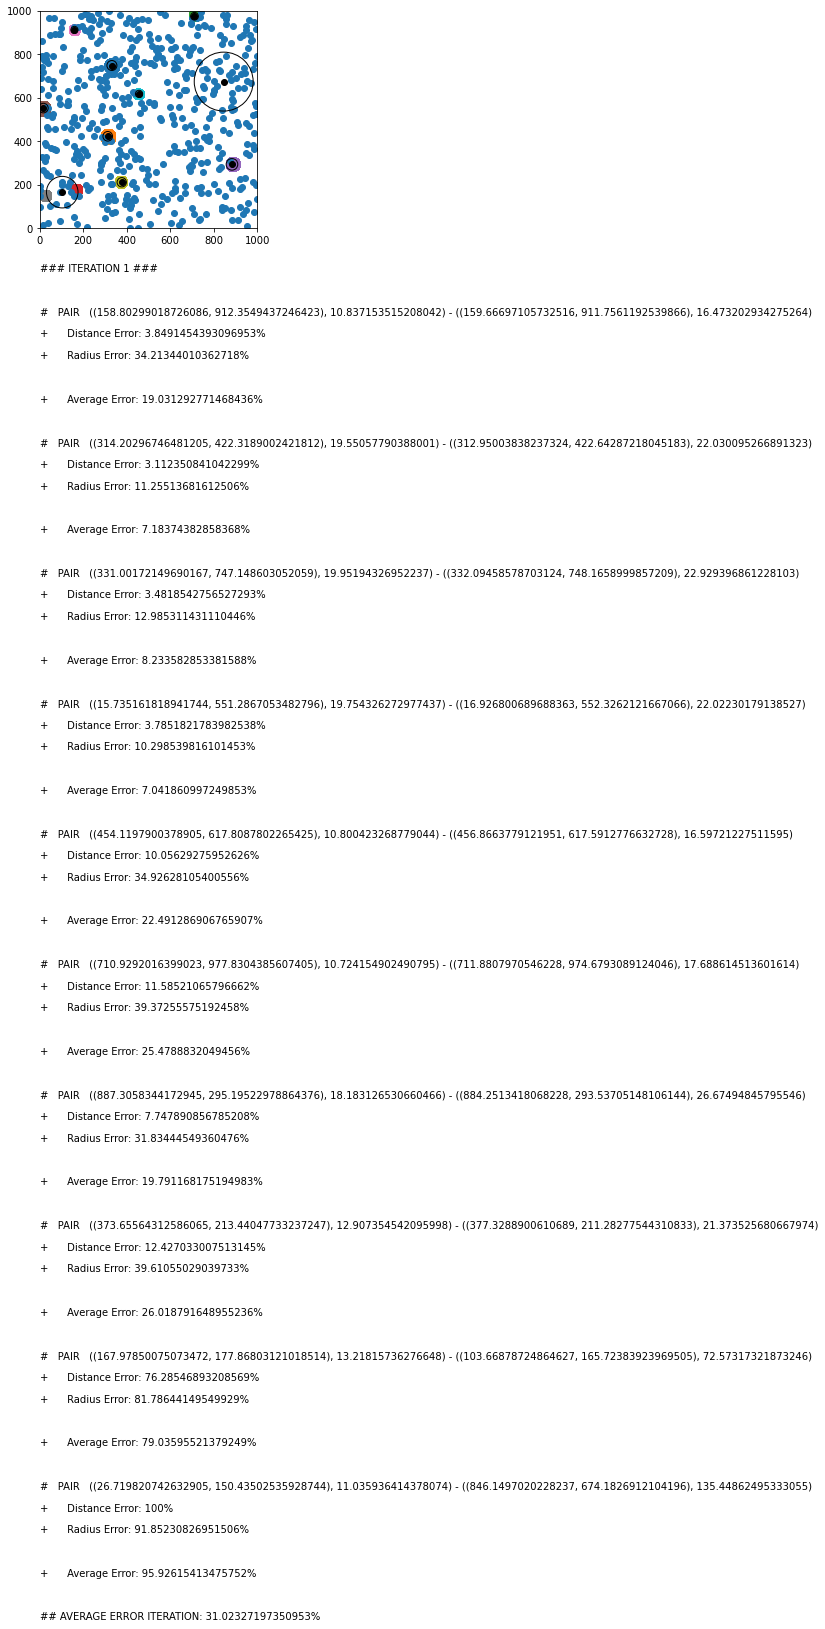

In [12]:
#################
# INITIAL  DATA #
#################

numberCircles =    int(input("Write the number of circles (Number greater or equal than 1): ")) 
minRadius =        float(input("Write the minimum value of the radius of the circles (Number greater or equal than 0): "))
maxRadius =        float(input("Write the maximum value of the radius of the circles (Number greater or equal than minRadius): "))
maximumLengthInX = float(input("Write the maximum length in X axis (Number greater or equal than 1): "))  
maximumLengthInY = float(input("Write the maximum length in Y axis (Number greater or equal than 1): "))  
numberPoints =     int(input("Write the number of desired points (With respect to previous data): "))  
noise =            float(input("Select the noise percentage (Number between 0 and 100): "))/100
fuzziness =        float(input("Select the fuzziness value (Number greater than 1): "))
iterations =       int(input("Write the number of iterations the function will perform (Number greater or equal than 1): ")) 
iterationsFCM =    int(input("Write the number of iterations the FCM algorithm will perform (Number greater or equal than 1): "))

#################
#  CALCULATIONS #
#################

totalAverages = []

for iteration in range(iterations):

    #Initial Figure
    fig, ax = plt.subplots()
    plt.xlim([0,maximumLengthInX])
    plt.ylim([0,maximumLengthInY])
    plt.gca().set_aspect('equal')

    circles, circlesPoints, randomPoints, points = generatePoints()
    plotPoints(circles, circlesPoints, randomPoints)
    
    circlesFCM = fuzzyCMeans(maximumLengthInX, maximumLengthInY, numberCircles, fuzziness, points, iterationsFCM)
    plotCenters(circlesFCM)
    
    pairOfCircles = calculatePairOfCircles(circles, circlesFCM)
    errors, average = calculateError(pairOfCircles)
    plotError(pairOfCircles, errors, average, iteration)
    
    totalAverages.append(average)
    
print("\n### TOTAL AVERAGE ERROR :",sum(totalAverages)/len(totalAverages),"% ###")